# Import necessary libraries and load the dataset #

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pandas nltk textblob gensim wordcloud matplotlib
import nltk
import re
from collections import Counter
from textblob import TextBlob
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
file_path = "C:\\Users\\zhi-n\\Documents\\FIT3163\\mimic-iv-note\\discharge.csv"
data = pd.read_csv(file_path)

# Overview of Data #

In [3]:
data.head(5)

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-DS-21,10000032,22595853,DS,21,2180-05-07 00:00:00,2180-05-09 15:26:00,\nName: ___ Unit No: _...
1,10000032-DS-22,10000032,22841357,DS,22,2180-06-27 00:00:00,2180-07-01 10:15:00,\nName: ___ Unit No: _...
2,10000032-DS-23,10000032,29079034,DS,23,2180-07-25 00:00:00,2180-07-25 21:42:00,\nName: ___ Unit No: _...
3,10000032-DS-24,10000032,25742920,DS,24,2180-08-07 00:00:00,2180-08-10 05:43:00,\nName: ___ Unit No: _...
4,10000084-DS-17,10000084,23052089,DS,17,2160-11-25 00:00:00,2160-11-25 15:09:00,\nName: ___ Unit No: __...


In [4]:
df = pd.DataFrame(data)
# Set the display option to show the full content of the 'text' column
pd.set_option('display.max_colwidth', None)
# Display the top 5 rows of the DataFrame
df[['note_id', 'text']].head(1)

note_id  \
0  10000032-DS-21   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

# Data Pre-processing #

### Summary of Data ###

#### 1. Number of Records  ####

In [5]:
num_records, num_columns = data.shape

print(f"The dataset contains {num_records} records and {num_columns} columns.")

The dataset contains 331794 records and 8 columns.


#### 2. Data Types  ####

In [6]:
data_types = data.dtypes
print("Data types of each feature:")
print(data_types)

Data types of each feature:
note_id       object
subject_id     int64
hadm_id        int64
note_type     object
note_seq       int64
charttime     object
storetime     object
text          object
dtype: object


# Data Analysis #

#### Checking for Inconsistencies, missing values  ####

In [7]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

note_id        0
subject_id     0
hadm_id        0
note_type      0
note_seq       0
charttime      0
storetime     17
text           0
dtype: int64


In [8]:
# Drop Missing Values
data.dropna(subset=['storetime'], inplace=True)

In [9]:
# Check for Duplicate Records
duplicate_rows = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


### Analyzing the 'text' column ###

#### Step 1: Data Preparation ###

In [10]:
# experimenting with subset
subset = data.sample(n=10000, random_state=42)
# subset = data
# subset=data.sample(frac=0.03, random_state=42)

In [11]:
# Data Cleaning
# 1. Remove special characters, numbers, and unwanted white spaces
import re

def clean_text(text):
    # Removing special characters and numbers
    text = re.sub('[^A-Za-z\s]', '', text)
    # Removing extra white spaces
    text = re.sub('\s+', ' ', text).strip()
    return text

subset['cleaned_text'] = subset['text'].apply(clean_text)

# 2. Convert all the text to lowercase
subset['cleaned_text'] = subset['cleaned_text'].str.lower()

# 3. Remove stopwords using SpaCy
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOP_WORDS])

subset['cleaned_text'] = subset['cleaned_text'].apply(remove_stopwords)

# Display the cleaned text
subset[['cleaned_text']].head(1)

,cleaned_text
1483,unit admission date discharge date date birth sex m service surgery allergies betablockers betaadrenergic blocking agts attending chief complaint stercoral perforation major surgical invasive procedure sigmoid resection end colostomy history present illness mr pmh significant erectile dysfunction sp inflatable penile prosthesis years ago cll severe respiratory compromise afib coumadin presented abdominal distention pain acute urinary retention patient relays voided yesterday multiple catheterization attempts failed urology consulted foley placement performed issues past medical history past medical history allergic rhinitis asthma chronic lymphocytic leukemia hld htn insomnia sleep apnea pain lumbar radiculopathy shoulder pain spinal stenosis congestive heart failure atrial fibrillation restless leg syndrome past surgical history penile prostesis years ago social history family history nc physical exam deceased pertinent results na brief hospital course mr admitted sterocoral perforation unknown etiology underwent emergent sigmoid resection end colostomy date postoperative course complicated afib w rvr transferred icu placed dilt gtt experienced respiratory decline requiring solumedrol bipap additional diuresis lasix preceding days intermittently febrile hypotensive requiring pressors hypoxic requiring intubation ventilator support cdiff positive treatment initiated appropriate consult services assistance sought including renal hematology evening mr worsening clinical status goals care discussed wife family members present bedside decision terminally extubate initiate cmo care start morphine gtt pronounced dead appx hours following extubation medications admission preadmission medication list accurate complete fluticasonesalmeterol diskus inh ih bid temazepam mg po qhsprn insomnia ipratropiumalbuterol neb neb neb qh bumetanide mg po bid gabapentin mg po qam gabapentin mg po qpm gabapentin mg po qhs azelastine mcg nasal daily ropinirole mg po qpm warfarin mg po daily mirtazapine mg po qhs tamsulosin mg po qhs simvastatin mg po qpm fluticasone propionate nasal spry nu daily diltiazem extendedrelease mg po daily montelukast mg po daily finasteride mg po daily oxycodoneacetaminophen mgmg tab po qhprn pain mild discharge medications na discharge disposition expired discharge diagnosis deceased discharge condition deceased discharge instructions na followup instructions


##### Tokenization ##### 

In [12]:
!python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")

     ---------------------------------------- 0.0/13.7 MB ? eta -:--:--
     --------------------------------------- 0.0/13.7 MB 640.0 kB/s eta 0:00:22
     --------------------------------------- 0.0/13.7 MB 435.7 kB/s eta 0:00:32
     --------------------------------------- 0.0/13.7 MB 435.7 kB/s eta 0:00:32
     --------------------------------------- 0.1/13.7 MB 297.7 kB/s eta 0:00:46
     --------------------------------------- 0.1/13.7 MB 374.1 kB/s eta 0:00:37
     --------------------------------------- 0.1/13.7 MB 437.6 kB/s eta 0:00:32
     --------------------------------------- 0.1/13.7 MB 425.3 kB/s eta 0:00:32
      -------------------------------------- 0.2/13.7 MB 541.9 kB/s eta 0:00:25
      -------------------------------------- 0.2/13.7 MB 576.2 kB/s eta 0:00:24
      -------------------------------------- 0.3/13.7 MB 542.5 kB/s eta 0:00:25
     - ------------------------------------- 0.4/13.7 MB 757.8 kB/s eta 0:00:18
     - ------------------------------------- 0.5

DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0-py3-none-any.whl#egg=en_core_web_sm==3.0.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617


In [13]:
# Step 1: Tokenization
subset['tokenized_text'] = subset['cleaned_text'].apply(lambda x: [token.text for token in nlp(x)])
subset[['tokenized_text']].head(1) 


,tokenized_text
1483,"[unit, admission, date, discharge, date, date, birth, sex, m, service, surgery, allergies, betablockers, betaadrenergic, blocking, agts, attending, chief, complaint, stercoral, perforation, major, surgical, invasive, procedure, sigmoid, resection, end, colostomy, history, present, illness, mr, pmh, significant, erectile, dysfunction, sp, inflatable, penile, prosthesis, years, ago, cll, severe, respiratory, compromise, afib, coumadin, presented, abdominal, distention, pain, acute, urinary, retention, patient, relays, voided, yesterday, multiple, catheterization, attempts, failed, urology, consulted, foley, placement, performed, issues, past, medical, history, past, medical, history, allergic, rhinitis, asthma, chronic, lymphocytic, leukemia, hld, htn, insomnia, sleep, apnea, pain, lumbar, radiculopathy, shoulder, pain, spinal, stenosis, congestive, heart, failure, atrial, fibrillation, restless, ...]"


##### Lemmatization ##### 

In [14]:
# Step 2: Lemmatization
# Summarization can benefit from this step as it can reduce the diversity of terms to their root forms, making processing more uniform.
import nltk
nltk.download('omw-1.4')
subset['lemmatized_text'] = subset['tokenized_text'].apply(lambda x: [token.lemma_ for token in nlp(' '.join(x))])
subset[['lemmatized_text']].head(1) 



[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\zhi-n\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,lemmatized_text
1483,"[unit, admission, date, discharge, date, date, birth, sex, m, service, surgery, allergy, betablocker, betaadrenergic, block, agts, attend, chief, complaint, stercoral, perforation, major, surgical, invasive, procedure, sigmoid, resection, end, colostomy, history, present, illness, mr, pmh, significant, erectile, dysfunction, sp, inflatable, penile, prosthesis, year, ago, cll, severe, respiratory, compromise, afib, coumadin, present, abdominal, distention, pain, acute, urinary, retention, patient, relay, void, yesterday, multiple, catheterization, attempt, fail, urology, consult, foley, placement, perform, issue, past, medical, history, past, medical, history, allergic, rhinitis, asthma, chronic, lymphocytic, leukemia, hld, htn, insomnia, sleep, apnea, pain, lumbar, radiculopathy, shoulder, pain, spinal, stenosis, congestive, heart, failure, atrial, fibrillation, restless, ...]"


#### Data Analysis ####

#### 1. Word Frequency ####

In [15]:
# Visualizing word frequencies
all_words = [word for tokens in subset['lemmatized_text'] for word in tokens]
word_freq = Counter(all_words)
print(word_freq.most_common(20))  # Display the 10 most common words

[('mg', 192835), ('po', 145652), ('discharge', 102018), ('daily', 98278), ('blood', 97171), ('patient', 80838), ('tablet', 79528), ('pain', 78842), ('history', 64406), ('day', 59344), ('medication', 58100), ('admission', 47588), ('pm', 46798), ('right', 40304), ('leave', 37359), ('normal', 35980), ('home', 35667), ('sig', 35553), ('date', 33637), ('present', 31920)]


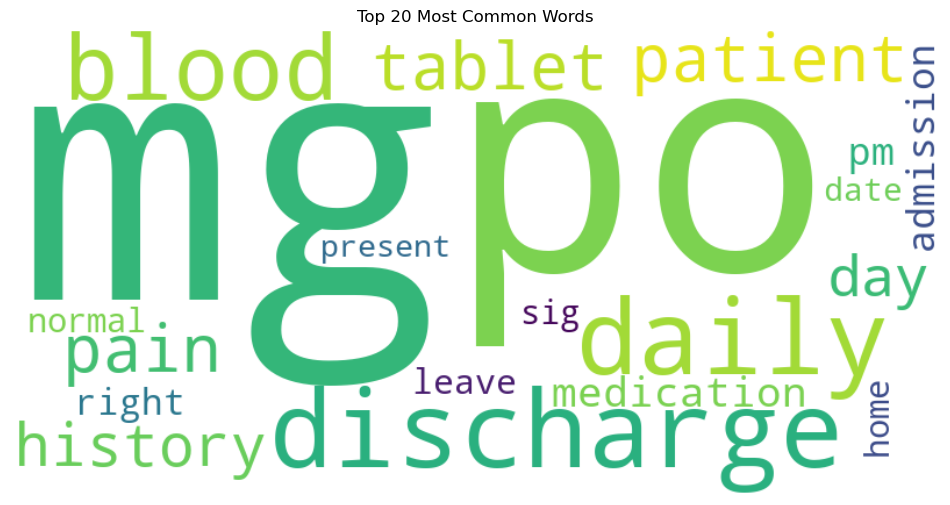

In [16]:
# Extract the 20 most common words and their counts
common_words = word_freq.most_common(20)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the frequency list into a dictionary
word_dict = dict(common_words)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)

# Plotting
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 20 Most Common Words')
plt.show()

#### 2. N-gram Analysis ####

Top 10 Most Common Bigrams:
'mg po': 91452
'po daily': 55968
'mg tablet': 33333
'pm blood': 26131
'sig tablet': 23699
'tablet sig': 20297
'tablet po': 20044
'po bid': 19675
'wbc rbc': 17236
'hgb hct': 17185


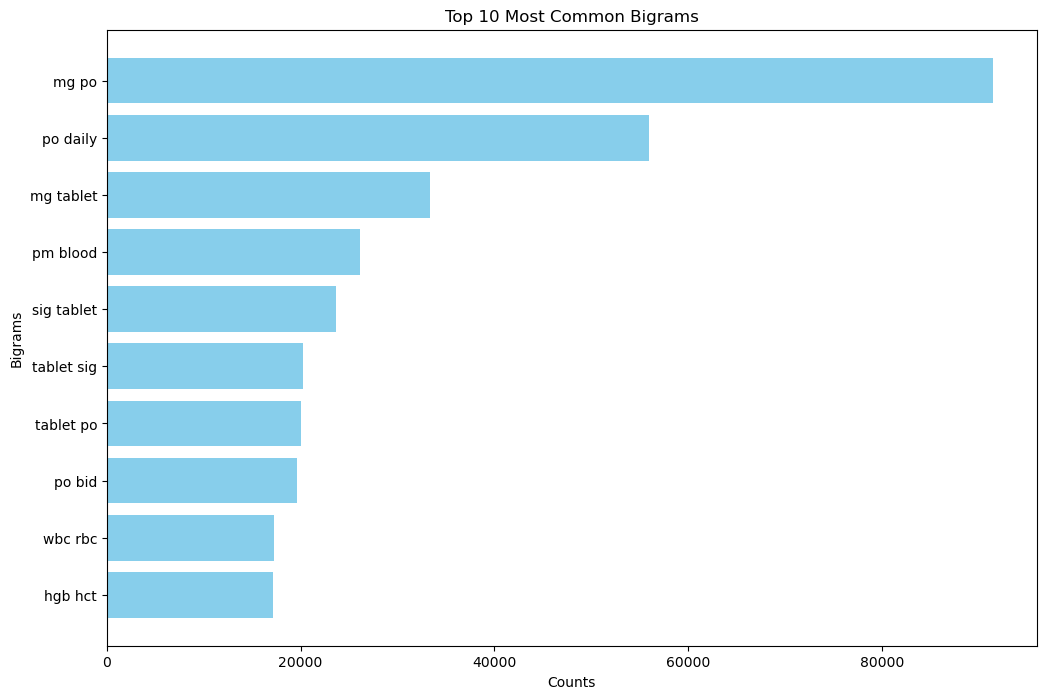

In [17]:
# look at the frequency of two or three word phrases (bigrams or trigrams). 
# This can provide insight into common phrases or topics.
from nltk import ngrams

bigrams = [bigram for tokens in subset['lemmatized_text'] for bigram in ngrams(tokens, 2)]
bigram_freq = Counter(bigrams)

# Top 10 bigrams
common_bigrams = bigram_freq.most_common(10)
bigram_words = [' '.join(word[0]) for word in common_bigrams]
bigram_counts = [word[1] for word in common_bigrams]

# Print the top 10 bigrams in text format
print("Top 10 Most Common Bigrams:")
for bigram, count in common_bigrams:
    print(f"'{' '.join(bigram)}': {count}")

plt.figure(figsize=(12,8))
plt.barh(bigram_words, bigram_counts, color='skyblue')
plt.title('Top 10 Most Common Bigrams')
plt.xlabel('Counts')
plt.ylabel('Bigrams')
plt.gca().invert_yaxis()
plt.show()

#### 3. POS (Part-of-Speech) Tagging ####


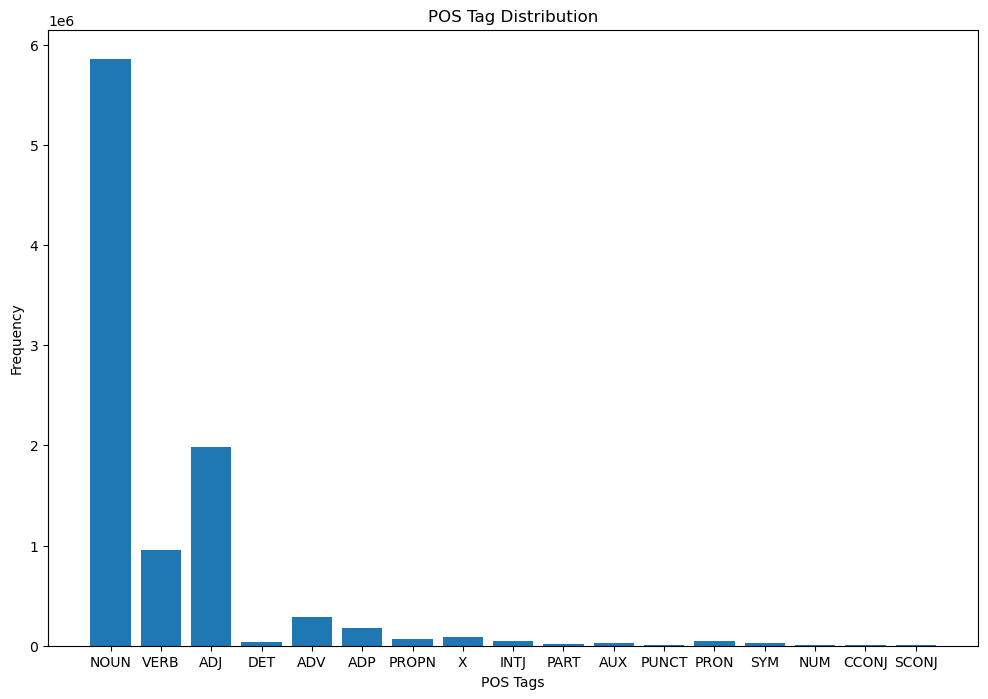

In [18]:
# The identification of words as nouns, verbs, adjectives, adverbs,
pos_tags = [token.pos_ for text in subset['lemmatized_text'] for token in nlp(' '.join(text))]
pos_freq = Counter(pos_tags)

plt.figure(figsize=(12, 8))
plt.bar(pos_freq.keys(), pos_freq.values())
plt.title("POS Tag Distribution")
plt.xlabel("POS Tags")
plt.ylabel("Frequency")
plt.show()

In [21]:
# Print frequencies in text form
for pos, freq in pos_freq.items():
    print(f"{pos}: {freq}")

NOUN: 5856019
VERB: 957509
ADJ: 1984487
DET: 34299
ADV: 288712
ADP: 179480
PROPN: 68105
X: 83072
INTJ: 47221
PART: 22054
AUX: 31758
PUNCT: 7638
PRON: 43976
SYM: 22683
NUM: 8445
CCONJ: 7281
SCONJ: 3517


#### 4. TF-IDF Analysis ####

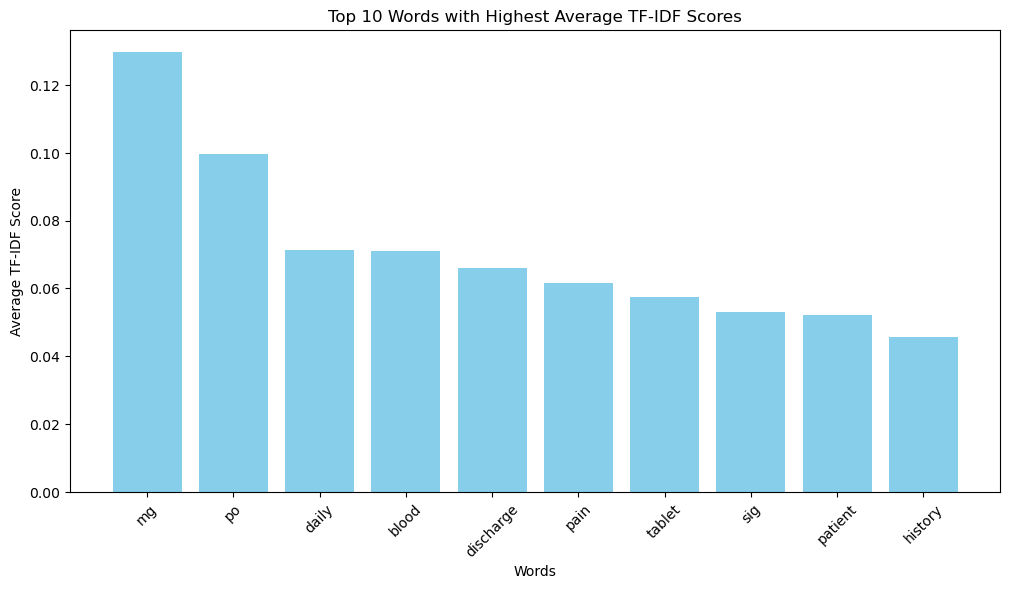


Top 10 Words with Highest Average TF-IDF Scores:
Word: mg, TF-IDF Score: 0.1297
Word: po, TF-IDF Score: 0.0997
Word: daily, TF-IDF Score: 0.0714
Word: blood, TF-IDF Score: 0.0711
Word: discharge, TF-IDF Score: 0.0659
Word: pain, TF-IDF Score: 0.0615
Word: tablet, TF-IDF Score: 0.0575
Word: sig, TF-IDF Score: 0.0531
Word: patient, TF-IDF Score: 0.0521
Word: history, TF-IDF Score: 0.0457


In [24]:
# determine the significance of words in a document or corpus
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Use the TF-IDF vectorizer without setting max_df
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(subset['cleaned_text'])
feature_names = vectorizer.get_feature_names_out()

# Calculate average TF-IDF scores for each term
avg_tfidf_scores = np.mean(tfidf_matrix, axis=0).tolist()[0]
sorted_indices = np.argsort(avg_tfidf_scores)[::-1][:10]

# Plot the top 10 terms
plt.figure(figsize=(12,6))
plt.bar(np.array(feature_names)[sorted_indices], np.array(avg_tfidf_scores)[sorted_indices], color='skyblue')
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Average TF-IDF Score")
plt.title("Top 10 Words with Highest Average TF-IDF Scores")
plt.show()

# Print the top 10 words with their scores
print("\nTop 10 Words with Highest Average TF-IDF Scores:")
for idx in sorted_indices:
    print(f"Word: {feature_names[idx]}, TF-IDF Score: {avg_tfidf_scores[idx]:.4f}")

#### 5. Lexical Diversity ####

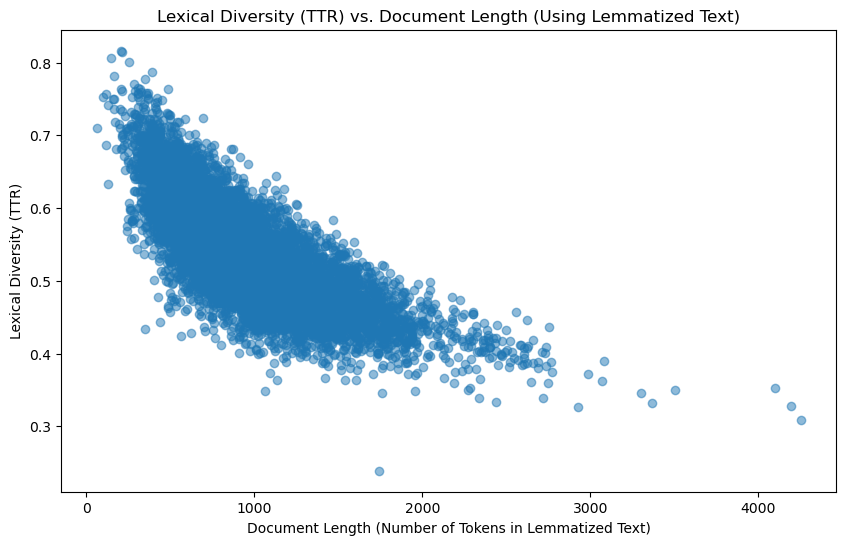

In [20]:
subset['num_tokens'] = subset['lemmatized_text'].apply(len)  # count number of tokens
subset['num_unique_tokens'] = subset['lemmatized_text'].apply(set).apply(len)  # count number of unique tokens
subset['TTR'] = subset['num_unique_tokens'] / subset['num_tokens']  # calculate TTR
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(subset['num_tokens'], subset['TTR'], alpha=0.5)
plt.title('Lexical Diversity (TTR) vs. Document Length (Using Lemmatized Text)')
plt.xlabel('Document Length (Number of Tokens in Lemmatized Text)')
plt.ylabel('Lexical Diversity (TTR)')
plt.show()